# Inbound Tourist Prediction - CNN Model


 * CNN

In [1]:
# 전처리기
from utils.data_loader import DataLoader
from utils.spliter import WindowGenerator

# 학습 효율성
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# 모델
from models.decompCNN import CNN

# Optimizer
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# 시각화
from utils.plot_util import plot

# Dataframe
import pandas as pd

## Data Load

CSV 파일로부터 데이터를 호출

사용하고자하는 특징의 속성 이름을 리스트로 전달

학습데이터와 평가 데이터를 분할하고자하는 날짜를 입력

```python3
utils.data_loader.load_csv(
    path: str,
    features: list,
    split_date: str,
    with_datelist=True
    
    if with_datelist:
        return train_set, test_set, [date_list, datelist_train, datelist_test]
    else:
        return train_set, test_set
)
```
* path: csv 파일 경로
* features: 사용하고자하는 특징 리스트
* split_date: Train, Test를 분리할 날짜

In [2]:
data_loader = DataLoader()
train, test, date_lists = data_loader.load_csv(path='./data/tourist_daily.csv', 
                                               features=['Date', 'Total_entry', 'seoul_hotel', 'incheon_airport', 'grocery_and_pharmacy_percent_change_from_baseline'], 
                                               split_date='2018-12-31')
train

array([[1.6883e+04, 5.0000e+01, 6.3000e+01, 0.0000e+00],
       [1.8076e+04, 5.0000e+01, 6.3000e+01, 0.0000e+00],
       [2.0572e+04, 5.0000e+01, 6.3000e+01, 0.0000e+00],
       ...,
       [5.8313e+04, 5.8000e+01, 8.9000e+01, 0.0000e+00],
       [4.6661e+04, 5.8000e+01, 8.9000e+01, 0.0000e+00],
       [3.7761e+04, 5.8000e+01, 8.9000e+01, 0.0000e+00]])

## Normalization (Option)

학습 loss 값을 줄여주고, 더 빠르게 minima에 도달 할 수 있도록 데이터를 전처리.

Min-max scale과 standard scale 제공

### Min-Max scale

```python3
utils.data_loader.minmaxScale(
    d: numpy
    return scaled_data
)
```

### Standard scale 

```python3
utils.data_loader.standardScale(
    d: numpy
    return scaled_data
)
```


* d: Input data for normalization

In [3]:
train = data_loader.standardScale(train)
test = data_loader.standardScale(test)
train

array([[-1.39886013, -1.2439275 , -0.23188153, -0.11397778],
       [-1.30677953, -1.2439275 , -0.23188153, -0.11397778],
       [-1.11412806, -1.2439275 , -0.23188153, -0.11397778],
       ...,
       [ 1.79887628, -0.70260688,  1.32512012, -0.11397778],
       [ 0.89952738, -0.70260688,  1.32512012, -0.11397778],
       [ 0.21258908, -0.70260688,  1.32512012, -0.11397778]])

## Spliting 

데이터 입력 sequence와 출력 sequence로 구성

얼마나 많은 데이터를 입력으로 사용할 것인지, 얼마나 많은 데이터를 출력으로 사용할 것인지, 그리고 얼마나 멀리 떨어지게 예측할것인지 설정

```python3
utils.spliter.WindowGenerator(
    data: numpy array,
    input_width: int,
    label_width: int,
    shift: int
)
```

In [4]:
# 15 sequence를 입력(input_width)으로하고, 30일 후(shift), 하루(label_width)를 예측
wg = WindowGenerator(train, input_width=15, label_width=1, shift=30)
twg = WindowGenerator(test, input_width=15, label_width=1, shift=30)
wg

Total window size: 45
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [44]

### Split 수행

In [5]:
# Split을 수행
train_x, train_y = wg.split_window()
test_x, test_y = twg.split_window()

print("Train X shape: {}".format(train_x.shape))
print("Train Y shape: {}".format(train_y.shape))

print("Test X shape: {}".format(test_x.shape))
print("Test Y shape: {}".format(test_y.shape))

Train X shape: (3243, 15, 4)
Train Y shape: (3243, 1)
Test X shape: (596, 15, 4)
Test Y shape: (596, 1)


### Reshape
CNN의 모양을 맞춰주기 위해서 반드시 필요

In [6]:
# Reshape for CNN
train_x = wg.reshape(train_x)
test_x = twg.reshape(test_x)
print(train_x.shape)

(3243, 1, 15, 4)


## Model

* CNN

### CNN
```python3
rnn.CNN(
    units: list, 
    output_seq: int, 
    dropout=0.25
    
    return tf.keras.Model
)
    
```

* units: hidden unit list.
* output_seq: output sequence length
* dropout: dropout ratio

In [7]:
# NOTE: 6개의 hidden units, 1 output sequences, dropout 0.5
model = CNN(64, 1, dropout=0.5)

## Compile and Training

### Hyper-parameters

In [8]:
lr = 0.001
optimizer = Adam(learning_rate=lr)
epochs = 50
validation_split=0.2
batch_size = 64
loss = 'mean_squared_error'

### Callbacks

In [9]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
tb = TensorBoard('logs')

### Train

In [10]:
model.compile(optimizer=optimizer, loss=loss)

history = model.fit(train_x,
                    train_y,
                    shuffle=True,
                    epochs=epochs,
                    callbacks=[es, rlr, tb],
                    validation_split=validation_split,
                    verbose=1,
                    batch_size=batch_size)

Epoch 1/50
 1/41 [..............................] - ETA: 0s - loss: 0.5156WARNING:tensorflow:From /Users/dhkim/Workspaces/Inbound_Tourist_Prediction/venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
41/41 [==============================] - 0s 12ms/step - loss: 0.3074 - val_loss: 0.2845
Epoch 2/50
41/41 [==============================] - 0s 9ms/step - loss: 0.2807 - val_loss: 0.2881
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.2740 - val_loss: 0.2539
Epoch 4/50
41/41 [==============================] - 0s 8ms/step - loss: 0.2648 - val_loss: 0.2795
Epoch 5/50
41/41 [==============================] - 0s 8ms/step - loss: 0.2519 - val_loss: 0.2539
Epoch 6/50
41/41 [==============================] - 0s 8ms/step - loss: 0.2504 - val_loss: 0.2562
Epoch 7/50
41/41 [=======

## Prediction

In [11]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

## Inverse Normalization (Option)
앞서 normalize 했던것을 되돌림

In [12]:
inv_train_predict = data_loader.inverseScale(train_predict)
inv_test_predict = data_loader.inverseScale(test_predict)

## Visualization

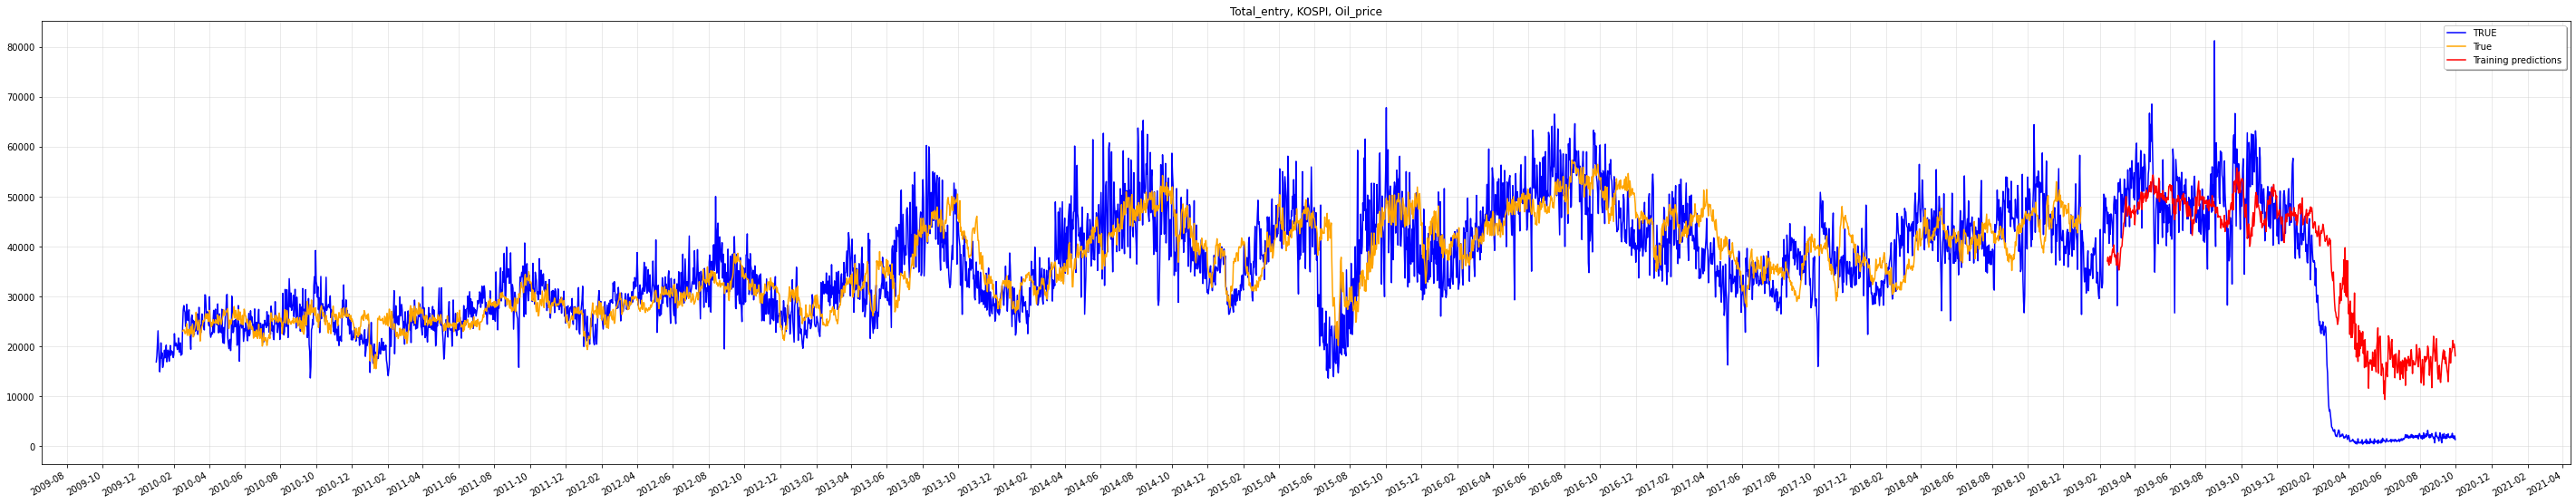

In [13]:
TRUE = pd.DataFrame(data_loader.original[:, 0:1], columns=["True"]).set_index(pd.Series(date_lists[0]))
prediction_train = wg.to_pandas(inv_train_predict[1:], date_lists[1], name="Train")
prediction_test = twg.to_pandas(inv_test_predict[1:], date_lists[2], name="Test")

plot(TRUE, prediction_train, prediction_test, show=True)